# **CVPS20 // Assignment 3**

assigned : **Oct 1, 2020**

DUE : **Oct 7, 2020 11:59pm**

## Characterizing the Fermi Haze/Bubbles

<img src="https://sci.esa.int/documents/34222/35279/1567216738403-Planck_GalacticHaze_Plus_Fermi_Bubbles_625.jpg" width=400x>

---

Our Galaxy is a fairly typical [spiral](https://en.wikipedia.org/wiki/Spiral_galaxy) galaxy with the Sun located about 8 kiloparsec from the Galactic center.  One of the consequences of that is that all-sky observations of the Universe beyond the Galaxy are always "contaminated" by the fact that telescopes must look through the Galaxy for certain pointings.  On the other hand, there is an entire field of astrophysics devoted to studying the Galactic interstellar medium ([ISM](https://en.wikipedia.org/wiki/Interstellar_medium)).  In 2009, the [Fermi Gamma-Ray Space Telescope](https://en.wikipedia.org/wiki/Fermi_Gamma-ray_Space_Telescope) released its first all-sky data of gamma-rays which allowed for an extremely detailed study of physical processes in the interstellar medium via gamma-ray emission.

In particular, gamma-rays in the ISM are produced in only a few ways, the most prominent being when protons, produced by exploding stars and flying through the Galaxy, slam into dust particles.  This creates particles called $\pi_0$'s that quickly decay into gamma-rays.  The next most prominent process is when electrons (also accelerated by exploding stars) smash into photons – e.g., produced by stars or left over from the Big Bang – and give them some of their energy, upscattering them to gamma-ray energies.  This process is called "Inverse Compton Scattering".  Note, these same electrons also produce synchrotron emission by spiraling around magnetic fields.

Thus, gamma-rays in the ISM "look like" dust because of the $\pi_0$ decay plus synchrotron because it is those same electrons that inverse Compton scatter low energy photons.  And so, also in 2009, we took sky-maps of dust emission and sky-maps synchrotron emission and fit those two "templates" to sky-maps of gamma-rays:

$ Fermi \ map = a_0 + a_1 \times dust \ map + a_2 \times synchrotron \ map$

When we removed this model from the original data, what we found in the residuals:

$ residuals = Fermi \ map - \left(a_0 + a_1 \times dust \ map + a_2 \times synchrotron \ map\right)$


was an enormous previously unknown structure in the Galaxy that looks like a giant "[Haze](https://iopscience.iop.org/article/10.1088/0004-637X/717/2/825/meta)" of gamma-rays towards the center of the Galaxy with sharp edges, giving it the shape of a pair of Fermi "[Bubbles](https://sci.esa.int/web/planck/-/50008-galactic-haze-and-bubbles)".  In this assignment, you will use techniques from class to uncover the Haze/Bubbles in the Fermi data, and determine how far off the Galactic plane that the bubbles stretch by finding their edges.

<b>

Rules for homeworks:

1. You may work with other students in the class, but if you do, each student with whom you worked <u>must</u> be listed in this notebook in the first cell below.  Direct copying from someone else's notebook is not permitted.

2. All solutions and outputs must be derived with python and the notebook should be "runable" by me (top to bottom) without errors.

3. Late homeworks will assess a 15% late penalty up to 3 days after the due date and a 50% late penalty until the end of the term (see CVPS20 syllabus).

</b>

<u>**Instructions for tasks that will be graded are in bold below.**</u>

---

**Please list the names of the other students with whom you worked for this assignment (if none, put "None").**

None

In the `data/sky_maps` folder, you will find three all-sky maps stored as binary `numpy` files:

- `dust_map.npy`, a map of ISM dust emission

- `synch_map.npy`, a map of ISM synchrotron emission

- `fermi_gamma_rays.npy`, a map of ISM gamma-ray emission


**Load these maps into arrays using `numpy`'s `load()` function.**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage.filters as flt
from skimage.filters import threshold_otsu
from scipy.signal import convolve2d
from scipy import ndimage
import math

# -- define the Sobel filters
sx = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
sy = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
Dust = np.load('/content/drive/My Drive/cvps20/data/sky_maps/dust_map.npy')
Fermi = np.load('/content/drive/My Drive/cvps20/data/sky_maps/fermi_gamma_rays.npy')
Synch = np.load('/content/drive/My Drive/cvps20/data/sky_maps/synch_map.npy')

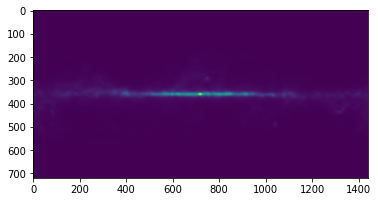

In [ ]:
plt.imshow(Dust)

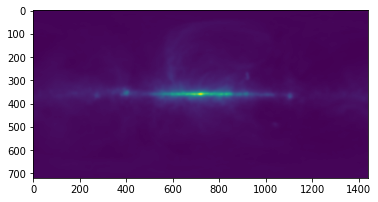

In [ ]:
plt.imshow(Synch)

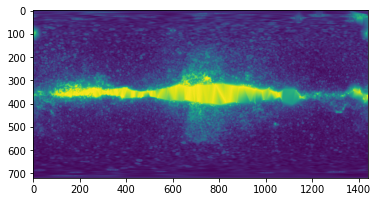

In [ ]:
plt.imshow(Fermi)

The linear combination described in the introduction is only a reasonable approximation for data away from the center of the Galactic plane.  Note that the coordinates of these maps are in *degrees* with the rows spanning $-90^{\circ}$ to $90^{\circ}$ (with the Galactic plane at $0^{\circ}$) and the columns spanning $-180^{\circ}$ to $180^{\circ}$.

**Make a `True/False` map that is True everywhere except within $12^{\circ}$ of the Galactic plane.  This will serve as a "mask" for the pixels that you will fit to the model.**

In [ ]:
Mask = np.ones(Dust.shape, dtype = bool)
Height = Mask.shape[0]
Mask[int(Height/2 - Height/180 *12) : int(Height/2 +Height/180*12), :] = False


Notice that you can sub-select pixels from 2D arrays using 2D T/F masks as follows:

In [1]:
import numpy as np

# -- create a 2D array
np.random.seed(302)
arr = np.random.rand(7, 4)

# -- sub-select only pixels
mask = arr > 0.6
sub = arr[mask]

print("array:\n", arr)
print("\nmask:\n", mask)
print("\nsubset:\n", sub)

array:
 [[0.63628121 0.82504234 0.34164473 0.73963926]
 [0.46915689 0.54279063 0.54566657 0.13160125]
 [0.15321095 0.25664691 0.43813099 0.03926267]
 [0.76366469 0.82908592 0.24730551 0.06485819]
 [0.29212617 0.51390937 0.30581508 0.12724558]
 [0.49677133 0.41615909 0.94611686 0.84010232]
 [0.31051752 0.54799126 0.26512182 0.65660217]]

mask:
 [[ True  True False  True]
 [False False False False]
 [False False False False]
 [ True  True False False]
 [False False False False]
 [False False  True  True]
 [False False False  True]]

subset:
 [0.63628121 0.82504234 0.73963926 0.76366469 0.82908592 0.94611686
 0.84010232 0.65660217]


**Using the method shown above with the mask you created to select the sub-set of sky pixels that are greater than $12^{\circ}$ away from the Galactic plane, fit the dust and synchrotron templates to the gamma-ray map by solving the Normal Equation using the linear algebra solution for only those pixels.**

In [ ]:
DustAway = Dust[Mask]
SynchAway = Synch[Mask]
FermiAway = Fermi[Mask]

P = np.stack([np.ones(DustAway.flatten().shape), DustAway.flatten(), SynchAway.flatten()]).T
PTy = np.dot(P.T, FermiAway.flatten())
PTP = np.dot(P.T, P)
PTPi = np.linalg.inv(PTP)

avec = np.dot(PTPi, PTy)

print("avec = {0}\n".format(avec))

avec = [0.04376335 7.87226175 3.34323523]



**Calculate the residuals as described in the introduction and display them with the mask, setting `cmap` to be "magma", and the `clims` to be `-0.2` to `0.2`.**  If everything has gone well, your residuals should look like the image below.

In [ ]:
Res = Fermi - (avec[0] + avec[1]*Dust + avec[2]*Synch)

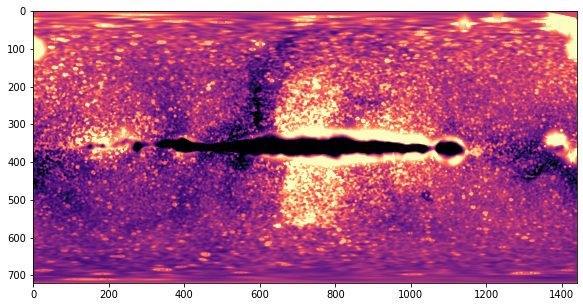

In [ ]:
plt.figure(figsize=[10,5])
plt.imshow(Res, cmap = 'magma')
plt.clim(-0.2,0.2)

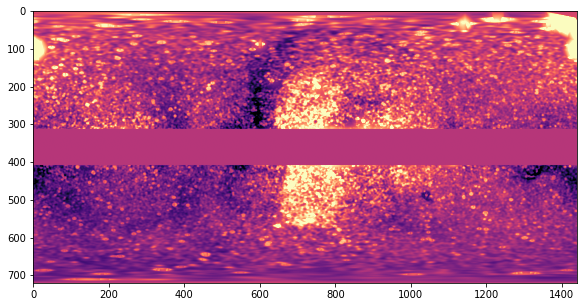

In [ ]:
plt.figure(figsize=[10,5])
plt.imshow(Res*Mask, cmap = 'magma')
plt.clim(-0.2,0.2)

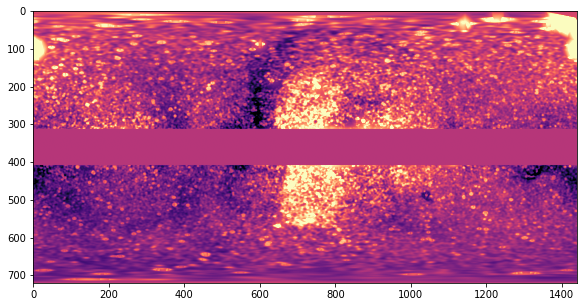

<b>Identify the location of the tip of the southern "edge" (the edge below the Galactic plane) of the Haze/Bubbles using two methods from class:

1. Gaussian differencing

2. Application of a Sobel filter to a median filtered version of the residuals

making sure to adjust the filter widths to a reasonable size to isolate the Southern edge and <u>justifying your choice</u>.</b>

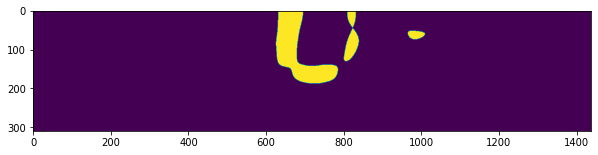

In [ ]:
SouthPart = Res[int(Height/2 +Height/180*12): , :]
SouthGau = flt.gaussian_filter(SouthPart, 25)

hor = SouthGau[1:-1, 1:-1] - SouthGau[1:-1, :-2]
ver = SouthGau[1:-1, 1:-1] - SouthGau[:-2, 1:-1]
tot = np.sqrt(hor**2 + ver**2)

Thresh = threshold_otsu(tot)
SouthBi = tot>0.0015

plt.figure(figsize=[10,5])
plt.imshow(SouthBi)

In [ ]:
#Find the number of the pixel of the tip

Index = np.where(SouthBi==True)
TipY = max(Index[0])

X = Index[1][Index[0]==TipY]
TipX = (max(X) + min(X))/2

In [ ]:
#Convert the number of the pixel to longtitude and latitude.

Lati = 90 - ( (SouthBi.shape[0]-TipY) * 180/Fermi.shape[0] )
Longi = -180 + TipX * 360/Fermi.shape[1]

print('The coordinate of the tip is {0}' u'\N{DEGREE SIGN}' ', ' '{1}' u'\N{DEGREE SIGN}'.format(Longi,Lati))

The coordinate of the tip is 1.25°, 59.25°


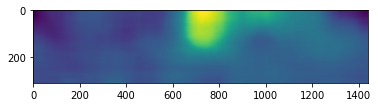

In [ ]:
#Use the second method

SouthMed = flt.median_filter(SouthPart, size=101)
plt.imshow(SouthMed)

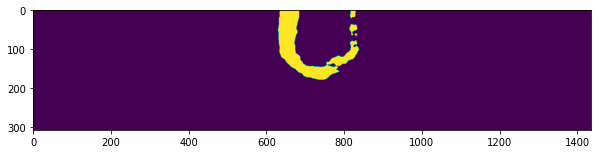

In [ ]:
Lx = convolve2d(SouthMed, sx)
Ly = convolve2d(SouthMed, sy)
LL = np.sqrt(Lx**2 + Ly**2)

LLGau = flt.gaussian_filter(LL[3:-3, 3:-3], 3)

Thresh2 = threshold_otsu(LLGau)
LLBi = LLGau>Thresh2*2

plt.figure(figsize=[10,5])
plt.imshow(LLBi)

In [ ]:
#Find the number of the pixel of the tip

Index2 = np.where(LLBi==True)
TipY2 = max(Index2[0])

X2 = Index2[1][Index2[0]==TipY2]
TipX2 = (max(X2) + min(X2))/2

In [ ]:
#Convert the number of the pixel to longtitude and latitude.

Lati2 = 90 - ( (SouthBi.shape[0]-TipY2) * 180/Fermi.shape[0] )
Longi2 = -180 + TipX2 * 360/Fermi.shape[1]

print('The coordinate of the tip is {0}' u'\N{DEGREE SIGN}' ', ' '{1}' u'\N{DEGREE SIGN}'.format(Longi2,Lati2))

The coordinate of the tip is 5.375°, 57.0°


* **The binary maps are clear and well-defined, the results of the tow methods are close, so the filter size should be reasonable.**

**Assuming that the Haze/Bubbles are centered at the Galactic center, how tall are they in kiloparsec?**

In [ ]:
#The distance from the Sun to the Galactic center is 8 kiloparsec, so Tall/8 = tan(latitude)

Tall = 8 * math.tan(math.radians((Lati+Lati2)/2))

print('The height of the Haze/Bubbles is {0} kiloparsec'.format(Tall) )

The height of the Haze/Bubbles is 12.865046497046952 kiloparsec
